In [62]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2

In [63]:
inp_dir = os.listdir('chest_xray')
print(inp_dir)

['chest_xray', 'test', 'train', 'val', '__MACOSX']


In [64]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_data(data_dir):
    data = []
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))     # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [65]:
train= get_data('chest_xray/train/')
val = get_data('chest_xray/val/')
test = get_data('chest_xray/test/')

C:\Users\naren\AppData\Local\Temp\ipykernel_1696\1708043060.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


Text(0.5, 1.0, 'NORMAL')

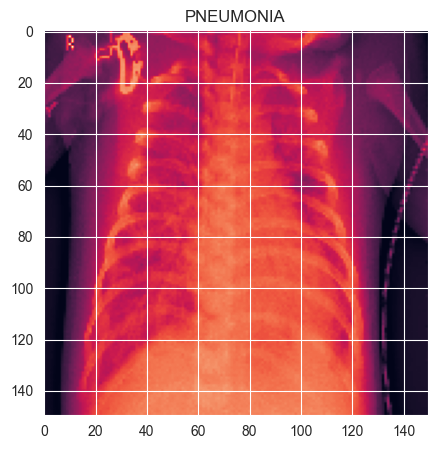

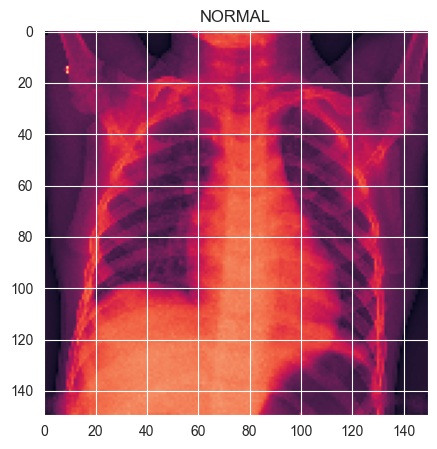

In [76]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0])
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

In [77]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [78]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [79]:

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)


In [80]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_5 (Batc  (None, 150, 150, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout_4 (Dropout)         (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 75, 75, 64)      

In [81]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [98]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 10 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/10
163/163 [==============================] - 372s 2s/step - loss: 0.2282 - accuracy: 0.9170 - val_loss: 8.8093 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 359s 2s/step - loss: 0.2103 - accuracy: 0.9277 - val_loss: 22.6268 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - 358s 2s/step - loss: 0.1918 - accuracy: 0.9323 - val_loss: 0.3884 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 353s 2s/step - loss: 0.1756 - accuracy: 0.9390 - val_loss: 71.2241 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.1670 - accuracy: 0.9419
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 352s 2s/step - loss: 0.1670 - accuracy: 0.9419 - val_loss: 11.4913 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 6/10
163/163 [==============================] - 36

In [99]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 7s 347ms/step - loss: 0.3527 - accuracy: 0.9103
Loss of the model is -  0.352708101272583
20/20 [==============================] - 10s 486ms/step - loss: 0.3527 - accuracy: 0.9103
Accuracy of the model is -  91.02563858032227 %


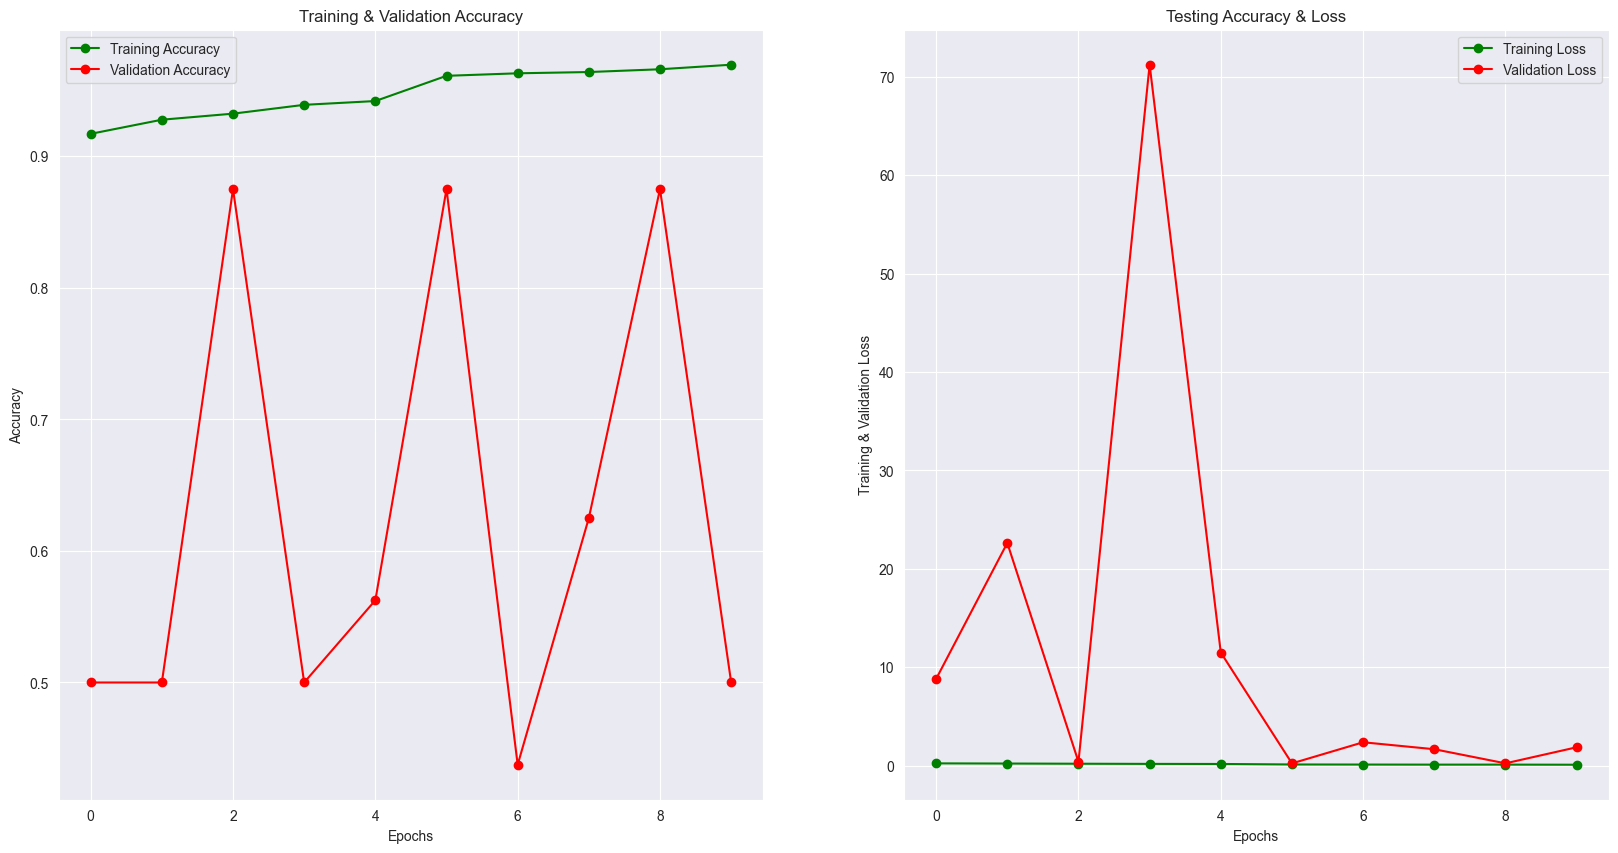

In [100]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [101]:
predictions =  (model.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

20/20 [==============================] - 4s 175ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [102]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.91      0.96      0.93       390
   Normal (Class 1)       0.92      0.83      0.87       234

           accuracy                           0.91       624
          macro avg       0.91      0.89      0.90       624
       weighted avg       0.91      0.91      0.91       624



In [103]:
cm = confusion_matrix(y_test,predictions)
cm

array([[373,  17],
       [ 39, 195]], dtype=int64)

In [110]:
predictions.shape

(624,)

In [104]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<AxesSubplot: >

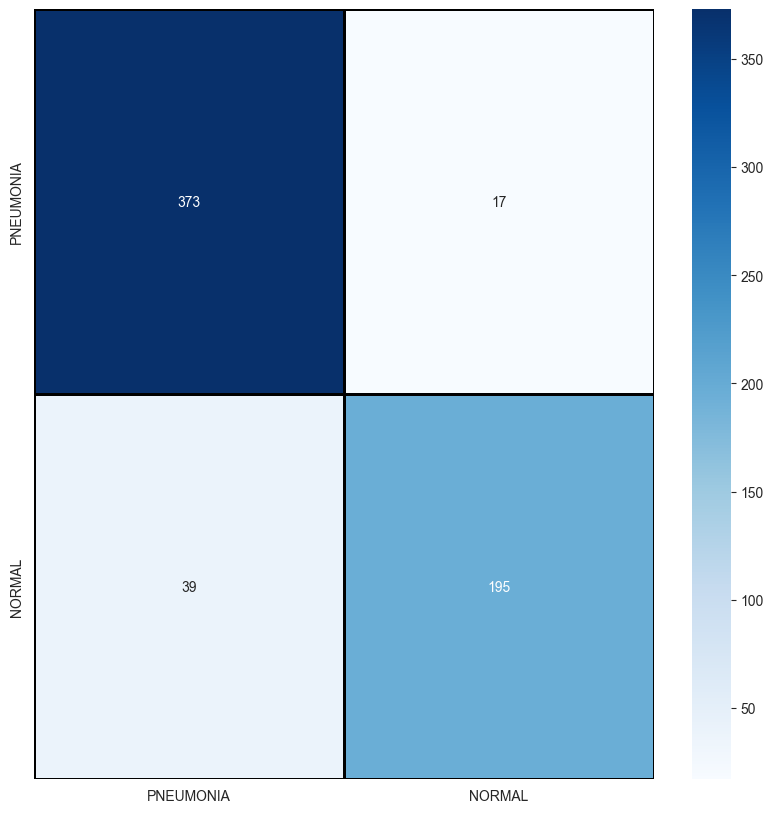

In [105]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [106]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

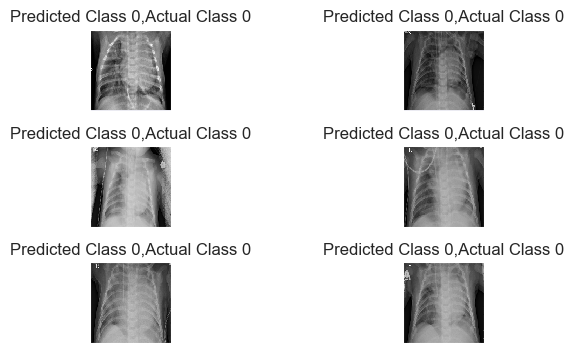

In [107]:
i = 0
for c in correct[:6]:
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

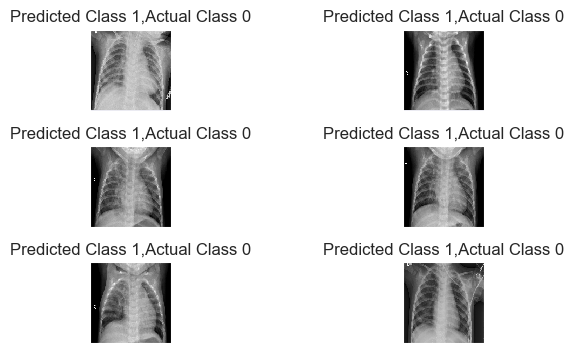

In [108]:
i = 0
for c in incorrect[:6]:
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1